**Table of contents**<a id='toc0_'></a>    
- [CNN Baseline model](#toc1_)    
  - [Notebook setup](#toc1_1_)    
  - [Exploratory analysis](#toc1_2_)    
  - [Dataset treatment](#toc1_3_)    
    - [Balancing](#toc1_3_1_)    
    - [Train val test split](#toc1_3_2_)    
  - [Model fine-tuning](#toc1_4_)    
    - [Making a simple prediction](#toc1_4_1_)    
    - [Dataset and dataloader](#toc1_4_2_)    
    - [Model architecture adaptation](#toc1_4_3_)    
    - [Model training](#toc1_4_4_)    
    - [Model evaluation](#toc1_4_5_)    
      - [Metrics](#toc1_4_5_1_)    
      - [Confusion matrices](#toc1_4_5_2_)    
      - [Saving the model](#toc1_4_5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[CNN Baseline model](#toc0_)

This notebook aims to provide a baseline CNN model for comparison with our auto-supervised approach to the deepfake audio detection.

The model choosed was [ConvNeXt-Tiny-AT](https://huggingface.co/topel/ConvNeXt-Tiny-AT). It is a CNN based audio model pretrained on the [AudioSet](http://research.google.com/audioset/index.html) dataset, to classify between 632 audio event classes in a collection of 2,084,320 human-labeled 10-second sound clips drawn from YouTube videos.

The model was pretrained on a supervised way, and will be fine-tuned also in a supervised way, to see how it compares with the self-supervised approach.

## <a id='toc1_1_'></a>[Notebook setup](#toc0_)

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.nn import functional as TF
import torchaudio
import torchaudio.functional as TAF
import pathlib

from audioset_convnext_inf.pytorch.convnext import ConvNeXt
from audioset_convnext_inf.utils.utilities import read_audioset_label_tags

PATH_TO_DATASET = "/home/elias/Projects/2024s2/MC959/AUDIOS/data/release_in_the_wild"

RANDOM_STATE = 7 # the biblical number of perfection =)

model = ConvNeXt.from_pretrained("topel/ConvNeXt-Tiny-AT", map_location='cpu')

print(
    "# params:",
    sum(param.numel() for param in model.parameters() if param.requires_grad),
)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

if "cuda" in str(device):
    model = model.to(device)

/home/elias/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using ckpt from HF
# params: 28222767


## <a id='toc1_2_'></a>[Exploratory analysis](#toc0_)

In [2]:
[x for x in os.listdir(PATH_TO_DATASET) if x.endswith('.csv')]

['meta.csv']

In [3]:
dataset_metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'meta.csv'))
dataset_metadata_df.head()

,file,speaker,label
0,0.wav,Alec Guinness,spoof
1,1.wav,Alec Guinness,spoof
2,2.wav,Barack Obama,spoof
3,3.wav,Alec Guinness,spoof
4,4.wav,Christopher Hitchens,bona-fide


In [4]:
# load the durations of each audio
import librosa

# Function to get the duration
def get_duration(filename):
    try:
        audio_path = os.path.join(PATH_TO_DATASET, filename)
        y, sr = librosa.load(audio_path, sr=None)
        return librosa.get_duration(y=y, sr=sr)
    except Exception as e:
        print(f"Could not load file {filename}: {e}")
        return None

# Apply the function to get durations and add them as a new column
dataset_metadata_df['duration'] = dataset_metadata_df['file'].apply(get_duration)
print("duration of calculations done")

duration of calculations done


In [5]:
print("total audio clips:", dataset_metadata_df.duration.count())
print("mean duration of audio clips (seconds):", dataset_metadata_df.duration.mean())
print("N speakers:", dataset_metadata_df.speaker.nunique())
print("Total audio time (hours):", dataset_metadata_df.duration.sum() / 3600)

total audio clips: 31779
mean duration of audio clips (seconds): 4.287800174643633
N speakers: 54
Total audio time (hours): 37.850556041666664


In [6]:
print("audio samples per speaker")
dataset_metadata_df.speaker.value_counts()

audio samples per speaker


speaker
Barack Obama                3636
Alec Guinness               3625
Donald Trump                3423
Bernie Sanders              2877
Ayn Rand                    2493
Bill Clinton                1832
Ronald Reagan               1536
Christopher Hitchens        1339
Winston Churchill            882
Martin Luther King           799
JFK                          669
Milton Friedman              589
Mark Zuckerberg              582
FDR                          471
Queen Elizabeth II           464
Louis Farrakhan              410
Alexandria Ocasio-Cortez     390
Nelson Mandela               381
Alan Watts                   378
Richard Nixon                359
Arnold Schwarzenegger        351
The Notorious B.I.G.         329
Boris Johnson                295
Dwight Eisenhower            268
George Carlin                248
George W. Bush               230
Adam Driver                  217
Gilbert Gottfried            208
Orson Welles                 202
Bill Burr                    201
Ma

In [7]:
print('Minutes per speaker')
dataset_metadata_df.groupby("speaker")['duration'].sum().sort_values(ascending=False) / 60

Minutes per speaker


speaker
Alec Guinness               262.317996
Barack Obama                243.583371
Bernie Sanders              223.375725
Donald Trump                209.212338
Ayn Rand                    176.117699
Ronald Reagan               108.115453
Bill Clinton                103.826186
Christopher Hitchens         98.959503
Mark Zuckerberg              59.149473
Martin Luther King           53.843203
Winston Churchill            47.467244
Milton Friedman              45.847965
JFK                          38.828141
Alexandria Ocasio-Cortez     37.178624
Queen Elizabeth II           35.231076
FDR                          35.227219
Louis Farrakhan              29.047594
Gilbert Gottfried            23.865337
George Carlin                23.661968
Boris Johnson                23.626683
Bill Burr                    22.838548
Arnold Schwarzenegger        21.763503
Alan Watts                   21.689932
John Cleese                  21.624093
Richard Nixon                21.523980
Orson Welles     

In [8]:
print("samples by class")
dataset_metadata_df['label'].value_counts()

samples by class


label
bona-fide    19963
spoof        11816
Name: count, dtype: int64

In [9]:
print("minutes by class")
dataset_metadata_df.groupby("label")['duration'].sum().sort_values(ascending=False) / 60

minutes by class


label
bona-fide    1245.358597
spoof        1025.674766
Name: duration, dtype: float64

In [10]:
# the proportions of samples and duration are diferrent, why?
print("duration mean of each class")
print("mean duration of spoof audios is bigger")
dataset_metadata_df.groupby("label")['duration'].mean()

duration mean of each class
mean duration of spoof audios is bigger


label
bona-fide    3.743000
spoof        5.208233
Name: duration, dtype: float64

In [11]:
print("Quantity of each audio per speaker")

spoof_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'spoof'].groupby("speaker").duration.count()
bonafide_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'bona-fide'].groupby("speaker").duration.count()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'spoof_count': spoof_per_speaker,
    'bona_fide_count': bonafide_per_speaker
}).fillna(0)  # Fill NaN with 0 if some speakers have no 'spoof' or 'bona-fide' samples

# Calculate total count and ratio for each speaker
counts_df['total'] = counts_df['spoof_count'] + counts_df['bona_fide_count']
counts_df['spoof_ratio'] = counts_df['spoof_count'] / counts_df['total']

counts_df.sort_values("spoof_ratio")

Quantity of each audio per speaker


,spoof_count,bona_fide_count,total,spoof_ratio
speaker,,,,
Donald Trump,155,3268,3423,0.045282
Nick Offerman,11,158,169,0.065089
Jeff Goldblum,4,56,60,0.066667
Barack Obama,334,3302,3636,0.091859
Lyndon Johnson,12,95,107,0.112150
Kamala Harris,4,25,29,0.137931
Calvin Coolidge,15,58,73,0.205479
Dwight Eisenhower,63,205,268,0.235075
Harry Truman,16,47,63,0.253968


In [12]:
print("Minutes of each audio per speaker")

import pandas as pd

# Sum durations for each label per speaker, converting to minutes
spoof_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'spoof'].groupby("speaker").duration.sum() / 60
bonafide_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'bona-fide'].groupby("speaker").duration.sum() / 60

# Combine into a single DataFrame
duration_df = pd.DataFrame({
    'spoof_duration (min)': spoof_per_speaker,
    'bona_fide_duration (min)': bonafide_per_speaker
}).fillna(0)  # Fill NaN with 0 if some speakers have no 'spoof' or 'bona-fide' samples

# Calculate total duration and ratio for each speaker
duration_df['total_duration (min)'] = duration_df['spoof_duration (min)'] + duration_df['bona_fide_duration (min)']
duration_df['spoof_ratio'] = duration_df['spoof_duration (min)'] / duration_df['total_duration (min)']

# Sort by spoof ratio
duration_df = duration_df.sort_values("spoof_ratio")

duration_df.sort_values("spoof_ratio")


Minutes of each audio per speaker


,spoof_duration (min),bona_fide_duration (min),total_duration (min),spoof_ratio
speaker,,,,
Donald Trump,13.816143,195.396195,209.212338,0.066039
Jeff Goldblum,0.500584,5.137945,5.638529,0.088779
Barack Obama,22.151278,221.432093,243.583371,0.090939
Nick Offerman,1.345788,9.537914,10.883701,0.123652
Kamala Harris,0.430552,2.103413,2.533965,0.169912
Robert Kardashian,1.309439,5.846300,7.155739,0.182991
Lyndon Johnson,1.801954,4.985355,6.787309,0.265489
Malcolm X,3.795770,9.966466,13.762235,0.275811
Harry Truman,1.674556,3.802586,5.477143,0.305735


## <a id='toc1_3_'></a>[Dataset treatment](#toc0_)

### <a id='toc1_3_1_'></a>[Balancing](#toc0_)

In [13]:
def balance_dataset(dataset_df, imbalance_threshold, seed):
    # Per speaker counts
    spoof_per_speaker = dataset_df[dataset_df.label == 'spoof'].groupby("speaker").duration.count()
    bonafide_per_speaker = dataset_df[dataset_df.label == 'bona-fide'].groupby("speaker").duration.count()

    # Combine counts into a single DataFrame and fill NaN with 0
    counts_df = pd.DataFrame({
        'spoof_count': spoof_per_speaker,
        'bona_fide_count': bonafide_per_speaker
    }).fillna(0)
    
    # Calculate total count and spoof ratio for each speaker
    counts_df['total'] = counts_df['spoof_count'] + counts_df['bona_fide_count']
    counts_df['spoof_ratio'] = counts_df['spoof_count'] / counts_df['total']

    # Initialize list to hold balanced data
    final_data = []
    
    for speaker in counts_df.index:
        speaker_data = dataset_df[dataset_df['speaker'] == speaker]
        
        # Separate spoof and bonafide samples
        spoof_samples = speaker_data[speaker_data['label'] == 'spoof']
        bonafide_samples = speaker_data[speaker_data['label'] == 'bona-fide']
        
        # Calculate the spoof ratio for this speaker
        spoof_ratio = counts_df.loc[speaker, 'spoof_ratio']
        
        # Check if the speaker's spoof/bona-fide ratio is within the threshold
        if spoof_ratio < imbalance_threshold or spoof_ratio > (1 - imbalance_threshold):
            # Balance spoof and bona-fide samples by truncating the excess
            target_count = min(len(spoof_samples), len(bonafide_samples))
            spoof_samples = spoof_samples.sample(n=target_count, random_state=seed)
            bonafide_samples = bonafide_samples.sample(n=target_count, random_state=seed)

        # Append both spoof and bona-fide samples for this speaker
        final_data.append(pd.concat([spoof_samples, bonafide_samples]))

    # Concatenate all balanced samples and sort by numeric part of 'file' column
    balanced_dataset_df = pd.concat(final_data)
    balanced_dataset_df['file_index'] = balanced_dataset_df['file'].str.extract(r'(\d+)').astype(int)
    balanced_dataset_df = balanced_dataset_df.sort_values(by='file_index').drop(columns='file_index').reset_index(drop=True)
    
    return balanced_dataset_df

dataset_metadata_df = balance_dataset(dataset_metadata_df, imbalance_threshold=0.5,seed=RANDOM_STATE)
dataset_metadata_df.head()

,file,speaker,label,duration
0,0.wav,Alec Guinness,spoof,1.819063
1,1.wav,Alec Guinness,spoof,11.096063
2,2.wav,Barack Obama,spoof,8.098062
3,3.wav,Alec Guinness,spoof,10.431062
4,4.wav,Christopher Hitchens,bona-fide,0.991000


### <a id='toc1_3_2_'></a>[Train val test split](#toc0_)

In [14]:
from sklearn.model_selection import train_test_split

train_metadata_df, test_metadata_df = train_test_split(dataset_metadata_df, test_size=0.2, random_state=RANDOM_STATE)

train_metadata_df, validation_metadata_df = train_test_split(train_metadata_df, test_size=0.2, random_state=RANDOM_STATE)

print("Train set classes")
print(train_metadata_df.label.value_counts())
print("Validation set classes")
print(validation_metadata_df.label.value_counts())
print("Test set classes")
print(test_metadata_df.label.value_counts())

Train set classes
label
bona-fide    6382
spoof        6187
Name: count, dtype: int64
Validation set classes
label
spoof        1649
bona-fide    1494
Name: count, dtype: int64
Test set classes
label
spoof        1984
bona-fide    1944
Name: count, dtype: int64


## <a id='toc1_4_'></a>[Model fine-tuning](#toc0_)

### <a id='toc1_4_1_'></a>[Making a simple prediction](#toc0_)

In [15]:
def load_and_preprocess_audio(path_to_audio, sample_rate = 32000, target_seconds_length = 10):
    """Load an audio of the memory and preprocess it to be adequate to ConvNeXt model"""
    audio_target_length = target_seconds_length * sample_rate  # 10 s

    waveform, sample_rate_ = torchaudio.load(path_to_audio)
    if sample_rate_ != sample_rate:
        print("Resampling from %d to 32000 Hz"%sample_rate_)
        waveform = TAF.resample(
            waveform,
            sample_rate_,
            sample_rate,
            )

    if waveform.shape[-1] < audio_target_length:
        # padding waveform
        missing = max(audio_target_length - waveform.shape[-1], 0)
        waveform = TF.pad(waveform, (0,missing), mode="constant", value=0.0)
    elif waveform.shape[-1] > audio_target_length:
        # cropping waveform
        waveform = waveform[:, :audio_target_length]

    waveform = waveform.contiguous()
    
    return waveform

Resampling from 16000 to 32000 Hz


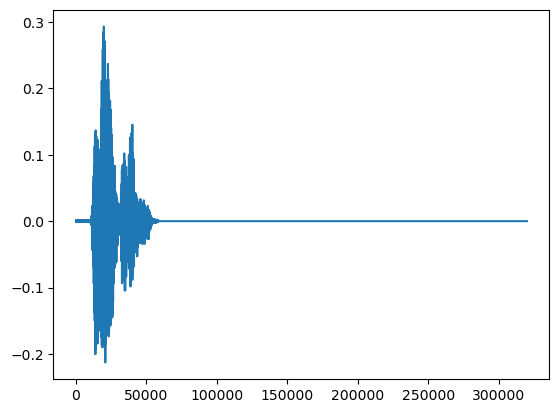

In [16]:
import matplotlib.pyplot as plt

sample_audio = dataset_metadata_df.file[0]
audio_path = os.path.join(PATH_TO_DATASET, sample_audio)

waveform = load_and_preprocess_audio(audio_path)

# seeing a waveform
plt.plot(waveform[0])

In [17]:
# making a output
waveform = waveform.to(device)

with torch.no_grad():
    model.eval()
    output = model(waveform)

logits = output["clipwise_logits"]
print("logits size:", logits.size())

probs = output["clipwise_output"]
# Equivalent: probs = torch.sigmoid(logits)
print("probs size:", probs.size())

lb_to_ix, ix_to_lb, id_to_ix, ix_to_id = read_audioset_label_tags('/home/elias/Projects/2024s2/MC959/AUDIOS/data/class_labels_indices_convnext.csv')

threshold = 0.1
sample_labels = np.where(probs[0].clone().detach().cpu() > threshold)[0]
print("\nPredicted labels using activity threshold 0.25:")

for l in sample_labels:
    print("    %s: %.3f"%(ix_to_lb[l], probs[0,l]))

logits size: torch.Size([1, 527])
probs size: torch.Size([1, 527])

Predicted labels using activity threshold 0.25:
    Speech: 0.877
    Male speech, man speaking: 0.146
    Speech synthesizer: 0.552


### <a id='toc1_4_2_'></a>[Dataset and dataloader](#toc0_)

In [18]:
from torch.utils.data import Dataset
from tqdm import tqdm

class AudioDataset(Dataset):
    """Dataset class from pytorch
    
    Cache dataset indicates if we want to load the entire dataset preprocessed
    on RAM (only works if 32GB memory or higher)"""
    def __init__(self, metadata_df: pd.DataFrame, audio_dir: str, cache_dataset = False):
        self.metadata_df = metadata_df
        self.audio_dir = audio_dir
        
        self.metadata_df['label_encoded'] = self.metadata_df['label'].map({
            "bona-fide": 0,
            "spoof": 1
        })
        
        self.cache_dataset = cache_dataset
        
        if cache_dataset:
            self.load_all_audios()
            
            
    def load_all_audios(self):
        """Load and preprocess all audios from the memory"""
        self.audios_cache = []

        for filename in tqdm(self.metadata_df['file'], desc="Loading audio files"):
            audio_path = os.path.join(self.audio_dir, filename)
            self.audios_cache.append(self.load_and_preprocess_audio(audio_path))

    def __len__(self):
        return len(self.metadata_df)
    
    def __getitem__(self, idx):
        if self.cache_dataset:
            return self.audios_cache[idx], self.metadata_df.iloc[idx]['label_encoded']
        
        # if not cache, load the individual file
        row = self.metadata_df.iloc[idx]
        # Load audio file
        audio_path = os.path.join(self.audio_dir, row['file'])
        
        return self.load_and_preprocess_audio(audio_path), row['label_encoded']
    
    
    def load_and_preprocess_audio(self,path_to_audio, sample_rate = 32000, target_seconds_length = 10):
        """Load an audio of the memory and preprocess it to be adequate to ConvNeXt model"""
        audio_target_length = target_seconds_length * sample_rate  # 10 s

        waveform, sample_rate_ = torchaudio.load(path_to_audio)
        if sample_rate_ != sample_rate:
            waveform = TAF.resample(
                waveform,
                sample_rate_,
                sample_rate,
                )

        if waveform.shape[-1] < audio_target_length:
            # padding waveform
            missing = max(audio_target_length - waveform.shape[-1], 0)
            waveform = TF.pad(waveform, (0,missing), mode="constant", value=0.0)
        elif waveform.shape[-1] > audio_target_length:
            # cropping waveform
            waveform = waveform[:, :audio_target_length]

        waveform = waveform.contiguous()
        
        return waveform
    
dataset_train = AudioDataset(train_metadata_df, PATH_TO_DATASET, cache_dataset=True)
dataset_val = AudioDataset(validation_metadata_df, PATH_TO_DATASET, cache_dataset=True)

Loading audio files: 100%|██████████| 3143/3143 [00:14<00:00, 211.05it/s]


### <a id='toc1_4_3_'></a>[Model architecture adaptation](#toc0_)

Our adapdatation is going to be simple: just change from 527 classes of the original AudioSet dataset to two nodes, predicting the spoof and bonafide probability

In [19]:
from torchinfo import summary

summary(model, input_size=(1, 320000))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNeXt                                 [1, 527]                  --
├─Spectrogram: 1-1                       [1, 1, 1001, 513]         --
│    └─STFT: 2-1                         --                        --
│    │    └─Conv1d: 3-1                  [1, 513, 1001]            (525,312)
│    │    └─Conv1d: 3-2                  [1, 513, 1001]            (525,312)
├─LogmelFilterBank: 1-2                  [1, 1, 1001, 224]         (114,912)
├─BatchNorm2d: 1-3                       [1, 224, 1001, 1]         448
├─ModuleList: 1-10                       --                        (recursive)
│    └─Sequential: 2-2                   [1, 96, 252, 56]          --
│    │    └─Conv2d: 3-3                  [1, 96, 252, 56]          1,632
│    │    └─LayerNorm: 3-4               [1, 96, 252, 56]          192
├─ModuleList: 1-11                       --                        (recursive)
│    └─Sequential: 2-3                   

In [20]:
model.head_audioset

Linear(in_features=768, out_features=527, bias=True)

In [21]:
# changing the output layer to two classes
from torch import nn
model.head_audioset = nn.Linear(in_features=768, out_features=1).to(device)

### <a id='toc1_4_4_'></a>[Model training](#toc0_)
Let's fine tune our model with the training data, using 10 epochs and a small learning rate.

All the weights are trained here (there are no layers frozen)

In [22]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm

# Hyperparameters
num_epochs = 10
learning_rate = 3e-4
batch_size = 8

train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": []
}

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        inputs, labels = batch[0].to(device), batch[1].float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs.squeeze(1))
        train_loss = criterion(outputs['clipwise_logits'].squeeze(1), labels)
        train_loss.backward()
        optimizer.step()
        running_train_loss += train_loss.item()

    avg_train_loss = running_train_loss / len(train_dataloader)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch[0].to(device), batch[1].float().to(device)
            outputs = model(inputs.squeeze(1))
            val_loss = criterion(outputs['clipwise_logits'].squeeze(1), labels)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_dataloader)

    # Store losses
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

loss_history_df = pd.DataFrame(history)
print("Training complete.")


Epoch [1/10], Train Loss: 0.0323, Validation Loss: 0.0141


Epoch [2/10], Train Loss: 0.0098, Validation Loss: 0.0015


Epoch [3/10], Train Loss: 0.0102, Validation Loss: 0.0052


Epoch [4/10], Train Loss: 0.0092, Validation Loss: 0.0049


Epoch [5/10], Train Loss: 0.0065, Validation Loss: 0.0023


Epoch [6/10], Train Loss: 0.0052, Validation Loss: 0.0054


Epoch [7/10], Train Loss: 0.0069, Validation Loss: 0.0062


Epoch [8/10], Train Loss: 0.0051, Validation Loss: 0.0135


Epoch [9/10], Train Loss: 0.0047, Validation Loss: 0.0024


Epoch [10/10], Train Loss: 0.0055, Validation Loss: 0.0150
Training complete.


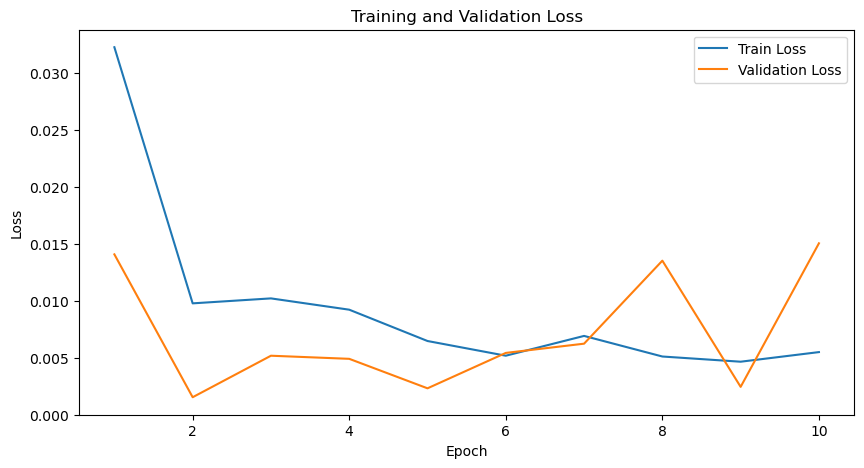

In [23]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history_df["epoch"], loss_history_df["train_loss"], label="Train Loss")
plt.plot(loss_history_df["epoch"], loss_history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### <a id='toc1_4_5_'></a>[Model evaluation](#toc0_)

Let's evaluate the model acording to the metrics defined on our planning

In [24]:
def make_predictions(model, metadata_df):
    """Make the predictions on the given files on metainfo_df
    
    Return a dataframe with the values of the predictions"""
    output_list = []
    dataloader = DataLoader(dataset=AudioDataset(metadata_df, PATH_TO_DATASET), batch_size=8)

    with torch.no_grad():
        model.eval()
        for batch in tqdm(dataloader, desc=f"Inference", leave=False):
            inputs = batch[0]  # (batch_size, channels, length)
            labels = batch[1].float()  # Convert labels to float for BCE loss

            # Move tensors to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs.squeeze(1))

            output_list.append(outputs['clipwise_output'].to('cpu').numpy())
            
    metadata_df['predict_proba'] = np.concatenate(output_list)
    metadata_df['prediction'] = metadata_df['predict_proba'].round().astype(int)
    
    return metadata_df

train_metadata_df_results = make_predictions(model, train_metadata_df)
train_metadata_df_results['train'] = True

val_metadata_df_results = make_predictions(model, validation_metadata_df)
val_metadata_df_results['train'] = False

results_df = pd.concat([train_metadata_df_results, val_metadata_df_results], axis='rows')
results_df = results_df.reset_index(drop=True)

# standarized way to see the results
results_df.head()

,file,speaker,label,duration,label_encoded,predict_proba,prediction,train
0,4804.wav,Alec Guinness,bona-fide,1.667000,0,0.000583,0,True
1,9710.wav,Arnold Schwarzenegger,spoof,1.773000,1,0.999876,1,True
2,23102.wav,Alexandria Ocasio-Cortez,bona-fide,2.231000,0,0.001000,0,True
3,15008.wav,Alec Guinness,bona-fide,8.573063,0,0.000734,0,True
4,27648.wav,Richard Nixon,bona-fide,1.811063,0,0.000810,0,True


#### <a id='toc1_4_5_1_'></a>[Metrics](#toc0_)

In [25]:
from sklearn.metrics import roc_curve
# Split data based on 'train' column
train_results = results_df[results_df['train'] == True]
non_train_results = results_df[results_df['train'] == False]

# Function to calculate TP, FP, FN, TN, Precision, Recall, Accuracy, and F1 Score
def calculate_metrics(df):
    TP = ((df['label_encoded'] == 1) & (df['prediction'] == 1)).sum()
    FP = ((df['label_encoded'] == 0) & (df['prediction'] == 1)).sum()
    FN = ((df['label_encoded'] == 1) & (df['prediction'] == 0)).sum()
    TN = ((df['label_encoded'] == 0) & (df['prediction'] == 0)).sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, accuracy, f1_score

# Function to calculate EER
def calculate_EER(df):
    y_true = df['label_encoded']
    y_pred = df['predict_proba']
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return eer

# Calculate metrics for training entries
train_precision, train_recall, train_accuracy, train_f1_score = calculate_metrics(train_results)
train_eer = calculate_EER(train_results)

# Calculate metrics for non-training (validation) entries
val_precision, val_recall, val_accuracy, val_f1_score = calculate_metrics(non_train_results)
val_eer = calculate_EER(non_train_results)

# Print metrics for training entries
print(f"Train -")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall: {train_recall:.4f}")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  F1 Score: {train_f1_score:.4f}")
print(f"  EER: {train_eer:.4f}")
print()

# Print metrics for validation entries
print(f"Validation -")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall: {val_recall:.4f}")
print(f"  Accuracy: {val_accuracy:.4f}")
print(f"  F1 Score: {val_f1_score:.4f}")
print(f"  EER: {val_eer:.4f}")


Train -
  Precision: 0.9997
  Recall: 0.9974
  Accuracy: 0.9986
  F1 Score: 0.9985
  EER: 0.0016

Validation -
  Precision: 0.9994
  Recall: 0.9933
  Accuracy: 0.9962
  F1 Score: 0.9964
  EER: 0.0020


#### <a id='toc1_4_5_2_'></a>[Confusion matrices](#toc0_)

In [26]:
# Function to create and print confusion matrix
def print_confusion_matrix(df, set_name):
    TP = ((df['label_encoded'] == 1) & (df['prediction'] == 1)).sum()
    FP = ((df['label_encoded'] == 0) & (df['prediction'] == 1)).sum()
    FN = ((df['label_encoded'] == 1) & (df['prediction'] == 0)).sum()
    TN = ((df['label_encoded'] == 0) & (df['prediction'] == 0)).sum()

    print(f"{set_name} Confusion Matrix:")
    print(f"          Predicted 0    Predicted 1")
    print(f"Actual 0    {TN:10}    {FP:10}")
    print(f"Actual 1    {FN:10}    {TP:10}\n")

# Print confusion matrix for training and validation sets
print_confusion_matrix(train_results, "Train")
print_confusion_matrix(non_train_results, "Validation")

Train Confusion Matrix:
          Predicted 0    Predicted 1
Actual 0          6380             2
Actual 1            16          6171

Validation Confusion Matrix:
          Predicted 0    Predicted 1
Actual 0          1493             1
Actual 1            11          1638



#### <a id='toc1_4_5_3_'></a>[Saving the model](#toc0_)

In [29]:
torch.save(model.state_dict(), os.path.join('..', 'models', 'baseline_model_state_dict.pth'))